# Data Explorer

This notebook visualizes what is going on in the dataset. 

Each `.aedat4` file contains an event stream that contains event batches.
Event batches contains events that occured in each frame. 
The number of events in each batch can vary, especially for each letter and each subject.

This notebook aims to help us understand our dataset better and how the authors collected it.
It will assist us in passing the data as input spikes to the spiking neural network we created.

#### Helpful References:
* [IniVation DV-Processing API Documentation](https://dv-processing.inivation.com/rel_1_7/api.html#api)
   * Particularly, the [`Accumulator` class](https://dv-processing.inivation.com/rel_1_7/api.html#_CPPv4N2dv11AccumulatorE) is helpful in explaining how events are stored in event batches

## 0 - Import packages and define helper functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time, os
import dv_processing as dv
from PIL import Image
import numpy as np
import json

In [38]:
def generate_gif(imgs, subject, letter):
    imgs = [Image.fromarray(img) for img in imgs]
    d = 100 # duration of each frame in GIF (in milliseconds)

    imgs[0].save(f"../animations/subject{subject}_{letter}.gif", save_all=True, append_images=imgs[1:], duration=d, loop=0)
    

def events_to_img(sample, resolution, gif=False):
    white = (255.0, 255.0, 255.0)
    black = (0.0, 0.0, 0.0)

    if gif:
        eviz = dv.visualization.EventVisualizer(resolution, white, black, black)
    else:
        eviz = dv.visualization.EventVisualizer(resolution, black, white, white)
    
    img = eviz.generateImage(sample)
    img = Image.fromarray(img).convert('L') # Convert to grayscale image (3 channels -> 1 channel)
    img = np.array(img) / 255.0

    return img

def parse_aedat(file, gif=False):

    # Read event stream from file and split into event packets
    recording = dv.io.MonoCameraRecording(file)
    resolution = recording.getEventResolution()

    min_batch_size, max_batch_size = np.inf, 0
    imgs = []

    if recording.isEventStreamAvailable():
        samples = 0
        while True:
            sample = recording.getNextEventBatch()
            if sample is None:
                break
            sample_length = len(sample.numpy())

            if min_batch_size > sample_length:
                min_batch_size = sample_length
            
            if max_batch_size < sample_length:
                max_batch_size = sample_length

            # Create image from sample of recording
            imgs.append(events_to_img(sample, resolution, gif))
            
            samples += 1


        # print("\n-----")
        # print("Total # of Samples:", samples)
        # print("Minimum # of Events For Recording:", min_batch_size)
        # print("Maximum # of Events For Recording:", max_batch_size)
    
    return resolution, imgs


def getDuration(file):
    record = dv.io.MonoCameraRecording(file)

    if record.isEventStreamAvailable():
        start, end = record.getTimeRange()
        duration = end - start 
    
    return duration # divide by 1e6 to convert to seconds

## 1 - Parse AEDAT4 Data

In [39]:
subject = 1
letter = 'f'
AEDAT = f"../data/aedat/subject{subject}/{letter}.aedat4"
GIF = False

duration = getDuration(AEDAT)
print(f"{AEDAT} duration: {duration / 1e6} secs")


../data/aedat/subject1/f.aedat4 duration: 81.728724 secs


Number of events in sample: 1515
Sample duration: 10041 microsecs
Image dims: (180, 240, 3)


Text(0.5, 1.0, 'Subject 1 Letter f - Frame 1')

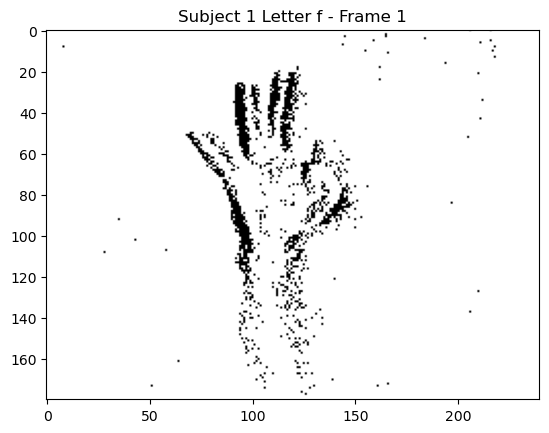

In [56]:
resolution, imgs = parse_aedat(AEDAT)
white = (255.0, 255.0, 255.0)
black = (0.0, 0.0, 0.0)

record = dv.io.MonoCameraRecording(AEDAT)
sample = record.getNextEventBatch()
start, end = sample.timestamps()[0], sample.timestamps()[-1]
# print(sample.timestamps())
print(f"Number of events in sample: {len(sample.numpy())}")
print(f"Sample duration: {end - start} microsecs")
# print(record.getEventTimeRange())
eviz = dv.visualization.EventVisualizer(resolution, white, black, black)
img = eviz.generateImage(sample)
print("Image dims:", img.shape) # Image in 3 channels 

plt.imshow(img)
plt.title("Subject 1 Letter f - Frame 1")

Text(0.5, 1.0, 'Subject 1 Letter f - Frame 1')

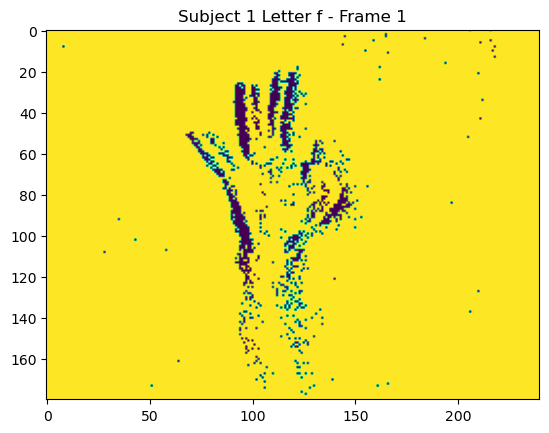

In [26]:
# Convert to grayscale image (3 channels -> 1 channel)
img = Image.fromarray(img).convert('L') 
img = np.array(img) / 255.0
plt.imshow(img)
plt.title("Subject 1 Letter f - Frame 1")

### Store image data into csv for all subjects

In [40]:
def store_data_per_letter(letter):
    subjects = [1, 2, 3, 4, 5] # List of subjects
    
    # Columns for the DataFrame
    cols = ["subject", "sample", "num_events", "duration", "image_array"]
    df = pd.DataFrame(columns=cols) # Create an empty DataFrame

    # Iterate over each subject
    for sub in subjects:
        # File path for the dataset
        FILE = f"../data/aedat/subject{sub}/{letter}.aedat4"
        # Check if the file exists
        if os.path.isfile(FILE):
            # Read event stream from file and split into event packets
            recording = dv.io.MonoCameraRecording(FILE)
            resolution = recording.getEventResolution()

            # Check if event stream is available
            if recording.isEventStreamAvailable():
                
                samples = 0
                while True:
                    # Get the next sample in the recording
                    sample = recording.getNextEventBatch()
                    # Break if there are no more samples
                    if sample is None:
                        break

                    # Calculate number of events and duration of the sample
                    num_events = len(sample.numpy())
                    duration = dv.EventStore.duration(sample)

                    # Create image from the sample 
                    img = events_to_img(sample, resolution).flatten()

                    # Save image into csv format
                    data = {
                        'subject': sub, 
                        'sample': samples, 
                        'num_events': num_events, 
                        'duration':duration, 
                        'image_array': [np.array(img)]
                        }
                    d = pd.DataFrame(data, dtype=object)
                    d['image_array'] = d['image_array'].apply(lambda x: json.dumps(x.tolist()))
                    
                    df = pd.concat([df, d])
                    samples += 1
        
    # Save DataFrame to a CSV file
    SAVE = f"../data/all/{letter}.csv"
    df.to_csv(SAVE, index=False)

    return

def gen_train_test_dfs(letters, train=0.7):
    # Columns for the DataFrames
    cols = ["letter", "subject", "sample", "num_events", "duration", "image_array"]
    # Create empty DataFrames for training and testing
    full_train = pd.DataFrame(columns=cols)
    full_test = pd.DataFrame(columns=cols)

    # Iterate over each letter
    for letter in letters:
        # List of subjects
        subjects = [1, 2, 3, 4, 5]
        # File path for the dataset
        FILE = f"../data/all/{letter}.csv"
 
        # Check if the file exists
        if os.path.isfile(FILE):
            # Read the CSV file into a DataFrame
            df = pd.read_csv(FILE)
            # Get the number of rows in the DataFrame
            size = df.shape[0]
            print("DF size:", size)
            
            # Insert the letter into the DataFrame
            df.insert(0, "letter", [letter] * size, True)

            # Iterate over each subject
            for sub in subjects:
                # Select rows where subject matches
                s = df[df["subject"] == sub]
                sub_size = s.shape[0]
                print(f"Total # of subject {sub} samples: {sub_size}")

            print()

            # Split the DataFrame into training and testing sets
            train_df = df.sample(frac=train)
            full_train = pd.concat([full_train, train_df])
            print("Randomized Trainset size:", train_df.shape[0])
            
            # Get the indices of the rows not in the training set
            test_idx = df.index.symmetric_difference(train_df.index)
            test_df = df.iloc[test_idx]
            full_test = pd.concat([full_test, test_df])
            print("Randomized Testset size:", test_df.shape[0])

            # Iterate over each subject
            for sub in subjects:
                # Select rows where subject matches in the training set
                s = train_df[train_df["subject"] == sub]
                print(f"# of subject {sub} trainset samples: {s.shape[0]}")
                
                # Select rows where subject matches in the testing set
                f = test_df[test_df["subject"] == sub]
                print(f"# of subject {sub} testset samples: {f.shape[0]}")

    # Save the training and testing DataFrames to CSV files
    full_train.to_csv("../data/trainset.csv", index=False)
    full_test.to_csv("../data/testset.csv", index=False)


In [ ]:
# Running this cell will take a while - BE WARNED
DIR = "../data/all"
if not os.path.isdir(DIR):
    os.makedirs(DIR)

letters = [i.split('/')[0].split('.')[0] for i in sorted(os.listdir("../data/aedat/subject1")) if "aedat" in i]
letters.append('z')

# This generates CSV files that store the following information for each letter:
# subject, sample, num_events, duration, image_array
for letter in letters:
    store_data_per_letter(letter)

## 2 - Random Sampling of Recording

In [39]:
# Creates trainset and testset from all letters and samples
# Will randomly get 70% of all data and set as trainset, the rest is testset
# Creates 2 files that are over 50MB
# TODO: Storing data a different way - images not being stored correctly
gen_train_test_dfs(letters)

Number of Samples for Each Letter:
{'a': 40481, 'b': 49949, 'c': 43108, 'd': 42240, 'e': 49063, 'f': 46786, 'g': 34995, 'h': 51738, 'i': 44758, 'k': 47822, 'l': 46688, 'm': 46150, 'n': 48477, 'o': 43250, 'p': 46153, 'q': 46030, 'r': 46985, 's': 47865, 't': 46968, 'u': 46454, 'v': 48276, 'w': 47476, 'x': 49203, 'y': 27026, 'z': 19809}


In [7]:
train = pd.read_csv('../data/trainset.csv', index_col=False)
train = train[~train.letter.str.contains('z')]
train

,letter,subject,sample,num_events,duration,image_array
0,a,2,1399,813,0 days 00:00:00.010004,[255 255 255 ... 255 255 255]
1,a,5,4934,1759,0 days 00:00:00.010002,[255 255 255 ... 255 255 255]
2,a,2,6254,233,0 days 00:00:00.010103,[255 255 255 ... 255 255 255]
3,a,3,6018,1854,0 days 00:00:00.010001,[255 255 255 ... 255 255 255]
4,a,2,3001,2048,0 days 00:00:00.010024,[255 255 255 ... 255 255 255]
...,...,...,...,...,...,...
761555,y,3,5499,3009,0 days 00:00:00.010000,[255 255 255 ... 255 255 255]
761556,y,2,6139,2822,0 days 00:00:00.010000,[255 255 255 ... 255 0 255]
761557,y,1,463,192,0 days 00:00:00.010020,[255 255 255 ... 255 255 255]
761558,y,2,1397,1194,0 days 00:00:00.010001,[255 255 255 ... 255 255 255]


In [153]:
letters = [i.split('/')[0].split('.')[0] for i in sorted(os.listdir("../data/aedat/subject1")) if "aedat" in i]
letters.append('z')  

sample_sizes = {} # Tracks number of samples for each letter
vowels = ['a', 'e', 'i', 'o', 'u'] # Subset to show distributions
s1, s2, s3, s4, s5 = {}, {}, {}, {}, {} # 
sub1, sub2, sub3, sub4, sub5 = {}, {}, {}, {}, {} # 
v1, v2, v3, v4, v5 = {}, {}, {}, {}, {} # Total samples for vowels


# Iterate over each letter
for letter in letters:
    # File path for the dataset
    FILE = f"../data/all/{letter}.csv"

    # Check if the file exists
    if os.path.isfile(FILE):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(FILE)
        # Get the number of rows in the DataFrame
        sample_sizes[letter] = df.shape[0]
        sub = df[df['subject'] == 1]
        sub1[letter] = sub.shape[0]

        sub = df[df['subject'] == 2]
        sub2[letter] = sub.shape[0]

        sub = df[df['subject'] == 3]
        sub3[letter] = sub.shape[0]

        sub = df[df['subject'] == 4]
        sub4[letter] = sub.shape[0]

        sub = df[df['subject'] == 5]
        sub5[letter] = sub.shape[0]
        
      

        if letter in vowels:
            sub = df[df['subject'] == 1]
            s1[letter] = sub.shape[0]

            sub = df[df['subject'] == 2]
            s2[letter] = sub.shape[0]

            sub = df[df['subject'] == 3]
            s3[letter] = sub.shape[0]

            sub = df[df['subject'] == 4]
            s4[letter] = sub.shape[0]

            sub = df[df['subject'] == 5]
            s5[letter] = sub.shape[0]




Text(0, 0.5, 'Number of Samples')

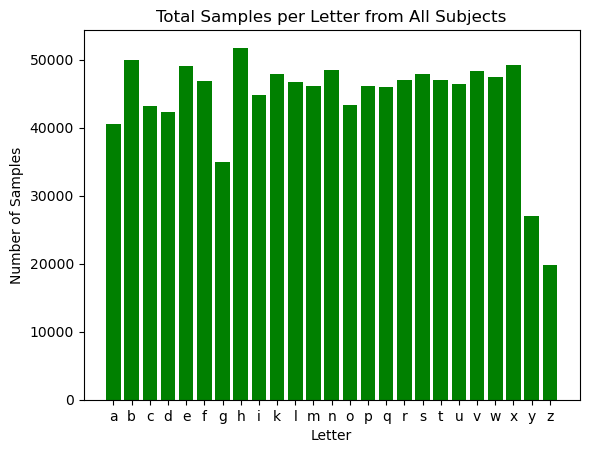

In [154]:
plt.bar(sample_sizes.keys(), sample_sizes.values(), color="g")
plt.title("Total Samples per Letter from All Subjects")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")

In [155]:
np.asarray(list(s1.values()))

array([2663, 6547, 6659, 4252, 7695])

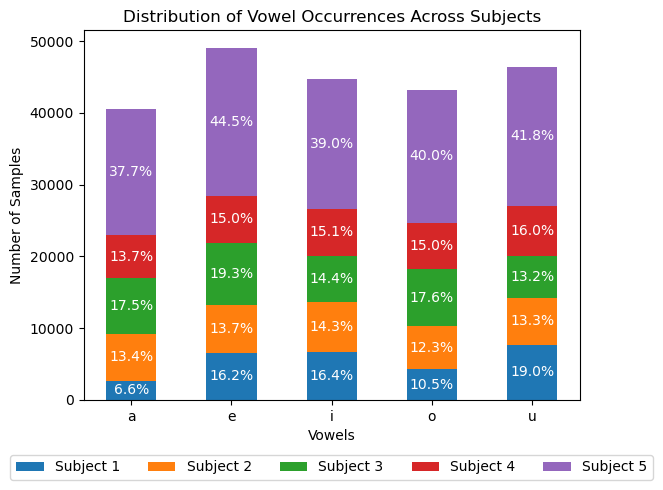

In [157]:

weight_counts = {
    "Subject 1": np.array(list(s1.values())),
    "Subject 2": np.array(list(s2.values())),
    "Subject 3": np.array(list(s3.values())),
    "Subject 4": np.array(list(s4.values())),
    "Subject 5": np.array(list(s5.values()))
}

width = 0.5
subset_letters = ['a', 'e', 'i', 'o', 'u']

fig, ax = plt.subplots()
bottom = np.zeros(len(subset_letters))
sample_keys = np.arange(len(subset_letters))

ax.set_title("Distribution of Vowel Occurrences Across Subjects")
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Vowels")
ax.set_xticks(sample_keys)
ax.set_xticklabels(subset_letters)


for i, (subject, num_samples) in enumerate(weight_counts.items()):
    total_samples = sample_sizes[vowels[i]]
    percentages = num_samples / total_samples * 100
    p = ax.bar(sample_keys, num_samples, width, label=subject, bottom=bottom)
    for i, (percentage, num_sample) in enumerate(zip(percentages, num_samples)):
        ax.text(i, bottom[i] + num_sample / 2, f"{percentage:.1f}%", ha='center', va='center', color='white')
    bottom += num_samples

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.13), ncol=len(weight_counts))

plt.show()

Text(0, 0.5, 'Number of Samples')

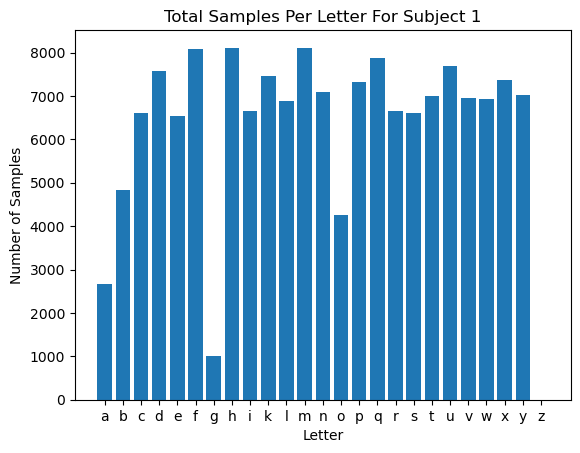

In [158]:
plt.bar(sub1.keys(), sub1.values(), color="tab:blue")
plt.title("Total Samples Per Letter For Subject 1")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")

Text(0, 0.5, 'Number of Samples')

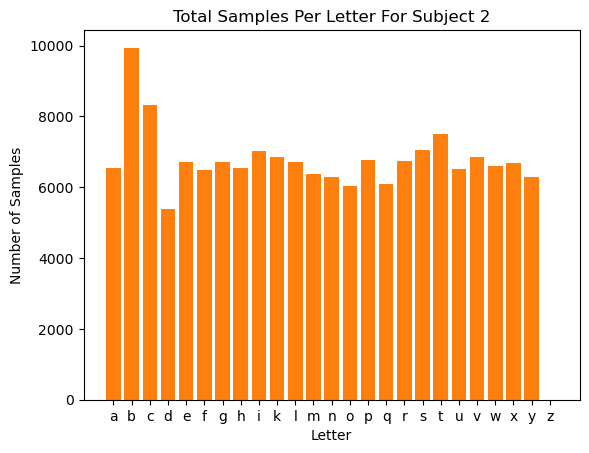

In [159]:
plt.bar(sub2.keys(), sub2.values(), color="tab:orange")
plt.title("Total Samples Per Letter For Subject 2")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")


Text(0, 0.5, 'Number of Samples')

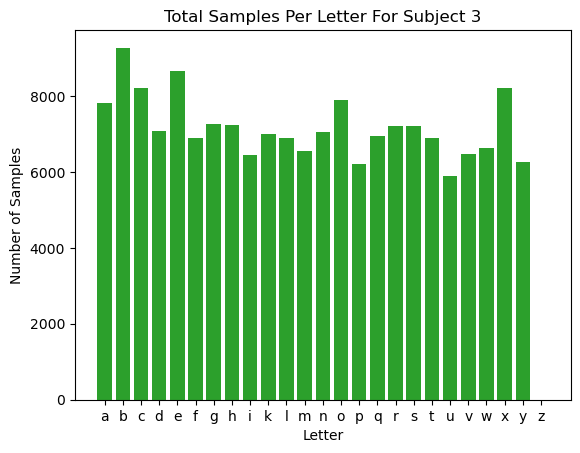

In [160]:
plt.bar(sub3.keys(), sub3.values(), color="tab:green")
plt.title("Total Samples Per Letter For Subject 3")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")

Text(0, 0.5, 'Number of Samples')

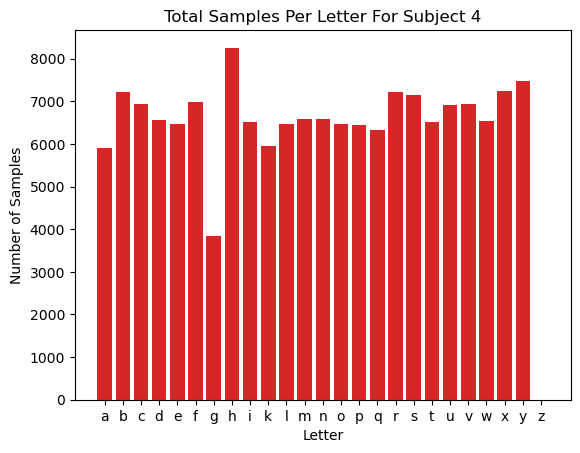

In [161]:

plt.bar(sub4.keys(), sub4.values(), color="tab:red")
plt.title("Total Samples Per Letter For Subject 4")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")

Text(0, 0.5, 'Number of Samples')

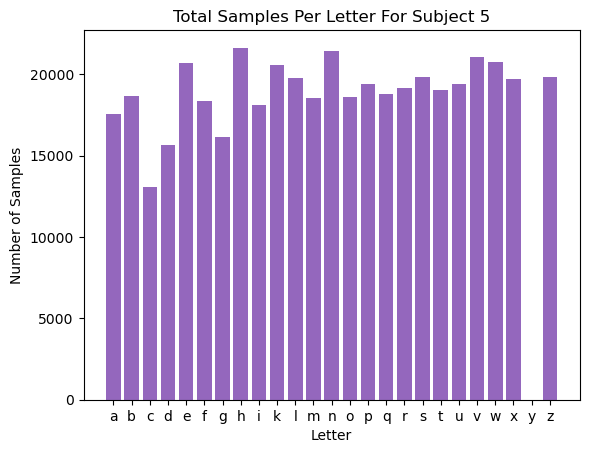

In [162]:

plt.bar(sub5.keys(), sub5.values(), color="tab:purple")
plt.title("Total Samples Per Letter For Subject 5")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")